In [1]:
import sys
sys.path.append('/home/monte.flora/python_packages/scikit-explain/')
sys.path.append('/home/monte.flora/python_packages/scikit-explain/tutorial_notebooks')
sys.path.append('/home/monte.flora/python_packages/master/ml_workflow')
sys.path.append('/work/mflora/ROAD_SURFACE')
import skexplain
import shap
import plotting_config
from skexplain.plot.base_plotting import PlotStructure
from skexplain.common.contrib_utils import get_indices_based_on_performance
import numpy as np
from bayeshist import bayesian_histogram
import matplotlib.pyplot as plt

from load_models_and_data import load_model_and_data
from probsr_config import FIGURE_MAPPINGS, UNITS
from display_names import to_readable_names, get_units
from load_explain_data import load_explain
#import similaritymeasures
from scipy.interpolate import interp1d
from top_features import top_features

In [2]:
def shap_to_curve(feature, shap_vals, X, bins):
    """Convert SHAP dots to a mean curve"""
    vals = shap_vals[feature]
    feature_vals = X[feature]
    
    inds = np.digitize(feature_vals, bins=bins) - 1
    mean_shap_vals = np.array([np.mean(vals.values[inds==i]) for i in np.unique(inds)])
    mean_shap_vals = 0.5*(mean_shap_vals[:-1]+mean_shap_vals[1:])
    
    return mean_shap_vals

In [3]:
from scipy.stats import spearmanr

def normalize(d):
    denom = (np.max(d) - np.min(d))
    if denom < 0.0000001:
        denom = 0.00001
    
    return d / denom

def rmse(d1, d2):
    return np.mean((d1-d2)**2)
    

def measure_corr(ale, shap_vals, pd, lime_vals, X_lime, ti_vals=None, X_ti=None, name=None, features=None):
    
    vals = {'ale' : [], 'shap' : [], 'pd' : [], 'lime' : [], 'ti':[]}
    val_weights = []
    
    if features is None:
        features = ale.attrs['features used']
    
    for feature in features:
        if feature in ['rural', 'urban']:
            continue
    
        ale_x = ale[f'{feature}__bin_values'].values
        ale_y =  np.mean(ale[f'{feature}__{name}__ale'].values, axis=0)
        
        pd_x = pd[f'{feature}__bin_values'].values
        pd_y = np.mean(pd[f'{feature}__{name}__pd'].values, axis=0)
        
        mean_shap = shap_to_curve(feature, shap_vals, X_shap, ale_x)
        mean_lime = shap_to_curve(feature, lime_vals, X_lime, ale_x)
        if ti_vals is not None:
            mean_ti = shap_to_curve(feature, ti_vals, X_ti, ale_x)
        
        data = X[feature].values.astype(float)
        bin_edges, beta_dist = bayesian_histogram(data, y)
        bin_centers = 0.5*(bin_edges[:-1] + bin_edges[1:])
        
        base_rate = beta_dist.median()
        ale_func = interp1d(ale_x, ale_y, fill_value="extrapolate")
        
        try:
            shap_func = interp1d(ale_x, mean_shap, fill_value="extrapolate")
        except:
            shap_func = interp1d(ale_x[:-1], mean_shap, fill_value="extrapolate")
           
        try:
            lime_func = interp1d(ale_x, mean_lime, fill_value="extrapolate")
        except:
            lime_func = interp1d(ale_x[:-1], mean_lime, fill_value="extrapolate")
        
        
        if ti_vals is not None:
            try:
                ti_func = interp1d(ale_x, mean_ti, fill_value="extrapolate")
            except:
                ti_func = interp1d(ale_x[:-1], mean_ti, fill_value="extrapolate")
        
        
        pd_func = interp1d(pd_x, pd_y, fill_value="extrapolate")
        
        ale_new = ale_func(bin_centers)
        shap_new = shap_func(bin_centers)
        pd_new = pd_func(bin_centers)
        lime_new = lime_func(bin_centers)
        
        if ti_vals is not None:
            ti_new = ti_func(bin_centers)
        
        
        #if name == 'Random Forest':
        #    fig = plt.figure(dpi=250)
        #    for d, label in zip([ale_new, shap_new, pd_new, base_rate], 
        #             ['ALE', 'SHAP', 'PD', 'BR']
        #            ):
            
        #        norm_d = d / (np.max(d) - np.min(d))
        #        plt.plot(bin_centers, norm_d, label=label)
            
            #corr = np.corrcoef(d, base_rate)[0][1]
            ##plt.scatter(base_rate, d, label=f'{label} : {corr:.3f}')
            #plt.plot(base_rate, d)
            #plt.xlabel('Base Rate')
            #plt.ylabel('Feature Effect')
        #plt.legend()

        br_norm = normalize(base_rate)

        vals['ale'].append(rmse(normalize(ale_new), br_norm))
        vals['pd'].append(rmse(normalize(pd_new), br_norm))
        vals['shap'].append(rmse(normalize(shap_new), br_norm))
        vals['lime'].append(rmse(normalize(lime_new), br_norm))
        if ti_vals is not None:
            vals['ti'].append(rmse(normalize(ti_new), br_norm))
        else:
            vals['ti'].append(0)
        
        val_weights.append(np.var(base_rate))

    return vals, val_weights

In [4]:
keys = ['ale', 'shap', 'pd', 'lime', 'ti']

data = [] 
hazards = ['tornado', 'severe_hail', 'severe_wind', 'road_surface']
for hazard in hazards: 
    (name, _), X, y = load_model_and_data(hazard, test=False)
    print(name, hazard)
    ale, _, shap_vals, X_shap, pd, lime_vals, X_lime, ti_vals, X_ti = load_explain(hazard, 
                                                                                   X.columns, return_pd=True)
    corr, weights = measure_corr(ale, shap_vals, pd, lime_vals, X_lime, ti_vals, X_ti, name, features=None)
    row = [np.sqrt(np.average(corr[key], weights=weights)) for key in keys]
    data.append(row)

Loading /work/mflora/ML_DATA/MODEL_SAVES/LogisticRegression_first_hour_tornado_under_standard_.pkl...


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


Loading data...
LogisticRegression tornado
Loading /work/mflora/ML_DATA/MODEL_SAVES/LogisticRegression_first_hour_severe_hail_under_standard_.pkl...
Loading data...
LogisticRegression severe_hail
Loading /work/mflora/ML_DATA/MODEL_SAVES/LogisticRegression_first_hour_severe_wind_under_standard_.pkl...
Loading data...
LogisticRegression severe_wind
Random Forest road_surface


overflow encountered in exp
overflow encountered in exp
overflow encountered in exp
overflow encountered in exp
overflow encountered in exp
overflow encountered in exp
overflow encountered in exp
overflow encountered in exp
overflow encountered in exp
overflow encountered in exp
overflow encountered in exp


In [5]:
import pandas as pd
columns = ['ALE', 'SHAP', 'PD', 'LIME', 'TI']
df = pd.DataFrame(data, columns=columns)

In [6]:
df

,ALE,SHAP,PD,LIME,TI
0,0.375045,0.373112,0.558411,0.563212,0.00000
1,0.409911,0.412206,0.565315,0.570334,0.00000
2,0.493028,0.504061,0.545753,0.712811,0.00000
3,1.085393,0.769632,0.689004,0.746736,1.21553


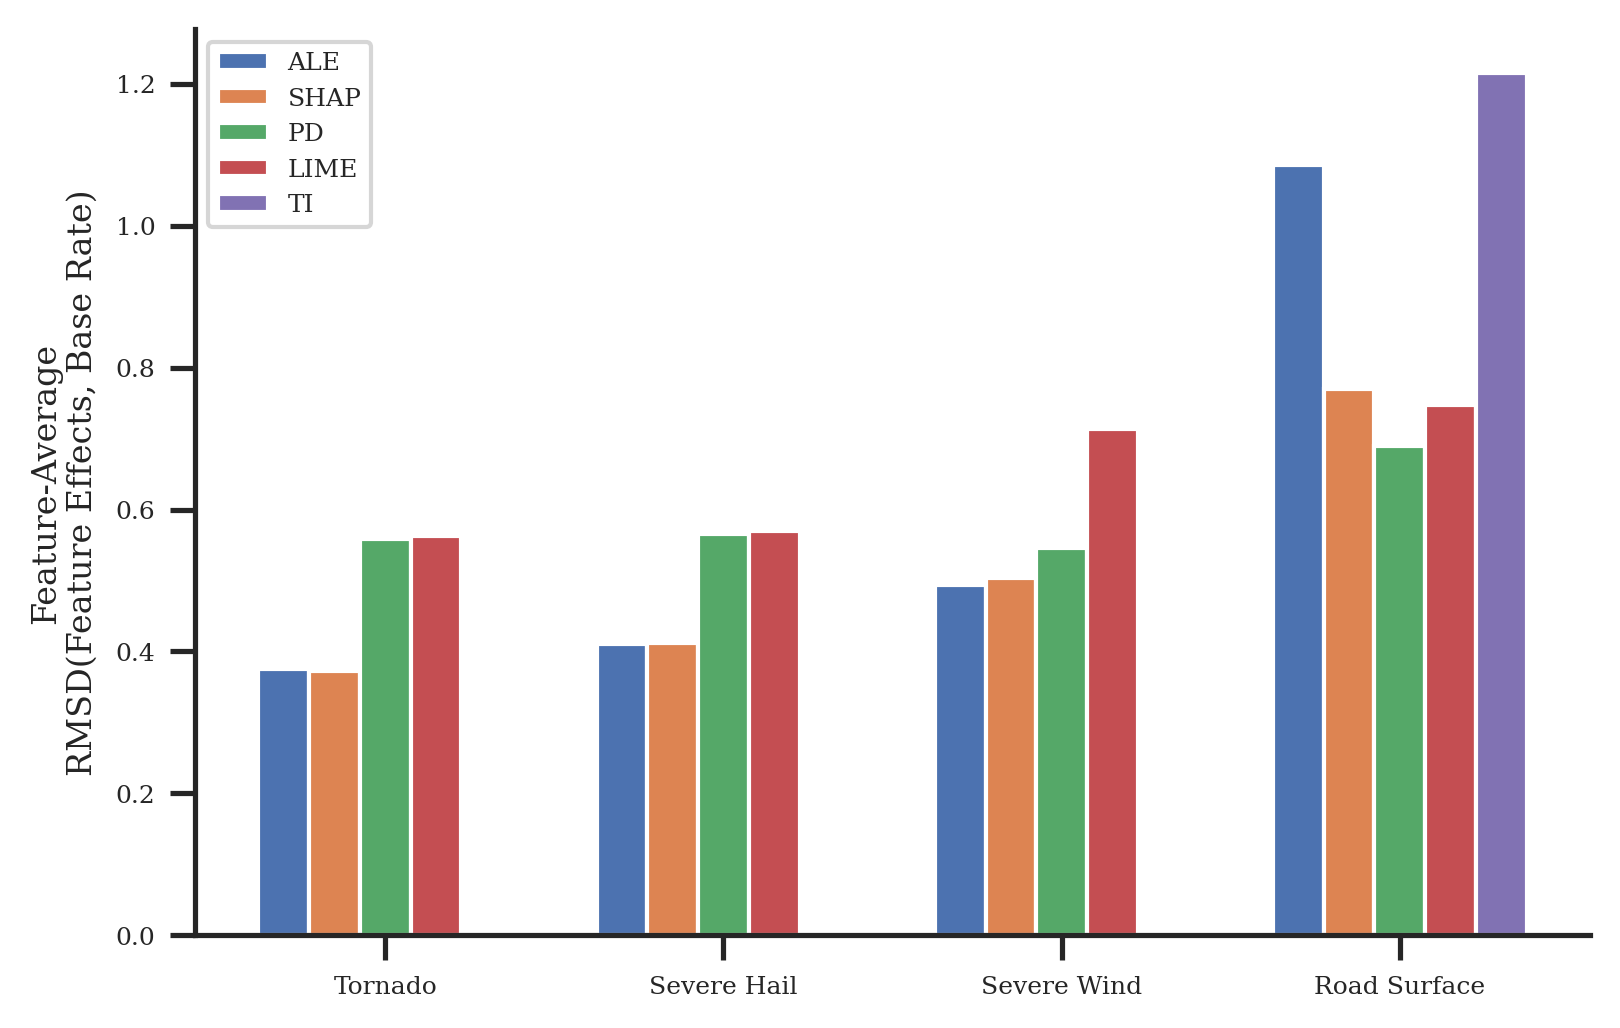

In [7]:
fig, ax = plt.subplots(dpi=300)
hazards = ['Tornado', 'Severe Hail', 'Severe Wind', 'Road Surface']

x = np.arange(len(hazards))  # the label locations
width = 0.15  # the width of the bars

pos = (x-(2*width), x-width, x, x+width, x+(2*width))

ax.bar(pos[0], df['ALE'], width=width, label='ALE')
ax.bar(pos[1] , df['SHAP'], width=width, label='SHAP')
ax.bar(pos[2], df['PD'], width=width, label='PD')
ax.bar(pos[3], df['LIME'], width=width, label='LIME')
ax.bar(pos[4], df['TI'], width=width, label='TI')

ax.set_ylabel('Feature-Average\nRMSD(Feature Effects, Base Rate)', fontsize=8)
ax.set_xticks(np.arange(len(hazards)))
ax.set_xticklabels(hazards)
ax.legend()

In [8]:
keys = ['ale', 'shap', 'pd']
data = [] 
hazards = ['road_surface']#['tornado', 'severe_hail', 'severe_wind', 'road_surface']
for hazard in hazards: 
    (name, _), X, y = load_model_and_data(hazard, test=False)
    ale, _, shap_vals, X_shap, pd = load_explain(hazard, X.columns, return_pd=True)
    corr, weights = measure_corr(ale, shap_vals, pd, name, features=top_features[hazard])
    row = [np.average(corr[key], weights=weights) for key in keys]
    data.append(row)

ValueError: too many values to unpack (expected 5)

In [ ]:
import pandas as pd
columns = ['ALE', 'SHAP', 'PD']
df = pd.DataFrame(data, columns=columns)

In [ ]:
df

In [ ]:
fig, ax = plt.subplots(dpi=300)
hazards = ['Tornado', 'Severe Hail', 'Severe Wind', 'Road Surface']

x = np.arange(len(hazards))  # the label locations
width = 0.15  # the width of the bars

ax.bar(x - width, df['ALE'], width=width, label='ALE')
ax.bar(x , df['SHAP'], width=width, label='SHAP')
ax.bar(x + width, df['PD'], width=width, label='PD')

ax.set_ylabel('Feature-Average\nRMSD(Feature Effects, Base Rate)', fontsize=8)
ax.set_xticks(np.arange(len(hazards)))
ax.set_xticklabels(hazards)
ax.legend()